# Efficient Object Detection with YOLOV8 and KerasCV

**Author:** [Gitesh Chawda](https://twitter.com/gitesh12_)<br>
**Date created:** 2023/06/26<br>
**Last modified:** 2023/06/26<br>
**Description:** Train custom YOLOV8 object detection model with KerasCV.

## Introduction

KerasCV is an extension of Keras for computer vision tasks. In this example, we'll see
how to train a YOLOV8 object detection model using KerasCV.

KerasCV includes pre-trained models for popular computer vision datasets, such as
ImageNet, COCO, and Pascal VOC, which can be used for transfer learning. KerasCV also
provides a range of visualization tools for inspecting the intermediate representations
learned by the model and for visualizing the results of object detection and segmentation
tasks.

If you're interested in learning about object detection using KerasCV, I highly suggest
taking a look at the guide created by lukewood. This resource, available at
[Object Detection With KerasCV](https://keras.io/guides/keras_cv/object_detection_keras_cv/#object-detection-introduction),
provides a comprehensive overview of the fundamental concepts and techniques
required for building object detection models with KerasCV.

In [ ]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q
!pip install keras-nlp

In [ ]:
print(keras.__version__)

NameError: name 'keras' is not defined

## Setup

In [ ]:
import os
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET

import tensorflow as tf
from tensorflow import keras

import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

## Load Data

For this guide, we will be utilizing the Self-Driving Car Dataset obtained from
[roboflow](https://public.roboflow.com/object-detection/self-driving-car). In order to
make the dataset more manageable, I have extracted a subset of the larger dataset, which
originally consisted of 15,000 data samples. From this subset, I have chosen 7,316
samples for model training.

To simplify the task at hand and focus our efforts, we will be working with a reduced
number of object classes. Specifically, we will be considering five primary classes for
detection and classification: car, pedestrian, traffic light, biker, and truck. These
classes represent some of the most common and significant objects encountered in the
context of self-driving cars.

By narrowing down the dataset to these specific classes, we can concentrate on building a
robust object detection model that can accurately identify and classify these important
objects.

The TensorFlow Datasets library provides a convenient way to download and use various
datasets, including the object detection dataset. This can be a great option for those
who want to quickly start working with the data without having to manually download and
preprocess it.

You can view various object detection datasets here
[TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/overview#object_detection)

However, in this code example, we will demonstrate how to load the dataset from scratch
using TensorFlow's `tf.data` pipeline. This approach provides more flexibility and allows
you to customize the preprocessing steps as needed.

Loading custom datasets that are not available in the TensorFlow Datasets library is one
of the main advantages of using the `tf.data` pipeline. This approach allows you to
create a custom data preprocessing pipeline tailored to the specific needs and
requirements of your dataset.

## Hyperparameters

In [ ]:
SPLIT_RATIO = 0.1
BATCH_SIZE = 20
LEARNING_RATE = 0.0001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0

A dictionary is created to map each class name to a unique numerical identifier. This
mapping is used to encode and decode the class labels during training and inference in
object detection tasks.

In [ ]:
# !unzip cornerscombined.voc.zip

In [ ]:
class_ids = ['cardcorner']
class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = "cornerscombined.voc/images"
path_annot = "cornerscombined.voc/xml"

# Get all XML file paths in path_annot and sort them
xml_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".xml")
    ]
)

# Get all JPEG image file paths in path_images and sort them
jpg_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)
print(f"Found {len(jpg_files)} images")

Found 240 images


The function below reads the XML file and finds the image name and path, and then
iterates over each object in the XML file to extract the bounding box coordinates and
class labels for each object.

The function returns three values: the image path, a list of bounding boxes (each
represented as a list of four floats: xmin, ymin, xmax, ymax), and a list of class IDs
(represented as integers) corresponding to each bounding box. The class IDs are obtained
by mapping the class labels to integer values using a dictionary called `class_mapping`.

In [ ]:

def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    image_name = root.find("filename").text
    image_path = os.path.join(path_images, image_name)

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    return image_path, boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_file in tqdm(xml_files):
    image_path, boxes, class_ids = parse_annotation(xml_file)
    image_paths.append(image_path)
    bbox.append(boxes)
    # print([b for b in boxes])
    classes.append(class_ids)
print("image_paths: ", len(image_paths))
print("bbox: ", len(bbox))
print("classes: ", len(classes))


  0%|          | 0/240 [00:00<?, ?it/s]

image_paths:  240
bbox:  240
classes:  240


Here we are using `tf.ragged.constant` to create ragged tensors from the `bbox` and
`classes` lists. A ragged tensor is a type of tensor that can handle varying lengths of
data along one or more dimensions. This is useful when dealing with data that has
variable-length sequences, such as text or time series data.

```python
classes = [
    [8, 8, 8, 8, 8],      # 5 classes
    [12, 14, 14, 14],     # 4 classes
    [1],                  # 1 class
    [7, 7],               # 2 classes
 ...]
```

```python
bbox = [
    [[199.0, 19.0, 390.0, 401.0],
    [217.0, 15.0, 270.0, 157.0],
    [393.0, 18.0, 432.0, 162.0],
    [1.0, 15.0, 226.0, 276.0],
    [19.0, 95.0, 458.0, 443.0]],     #image 1 has 4 objects
    [[52.0, 117.0, 109.0, 177.0]],   #image 2 has 1 object
    [[88.0, 87.0, 235.0, 322.0],
    [113.0, 117.0, 218.0, 471.0]],   #image 3 has 2 objects
 ...]
```

In this case, the `bbox` and `classes` lists have different lengths for each image,
depending on the number of objects in the image and the corresponding bounding boxes and
classes. To handle this variability, ragged tensors are used instead of regular tensors.

Later, these ragged tensors are used to create a `tf.data.Dataset` using the
`from_tensor_slices` method. This method creates a dataset from the input tensors by
slicing them along the first dimension. By using ragged tensors, the dataset can handle
varying lengths of data for each image and provide a flexible input pipeline for further
processing.

In [ ]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))


Splitting data in training and validation data

In [ ]:
# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)
print("num_val: ", num_val)
print("len total: ", len(xml_files))

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

num_val:  24
len total:  240


Let's see about data loading and bounding box formatting to get things going. Bounding
boxes in KerasCV have a predetermined format. To do this, you must bundle your bounding
boxes into a dictionary that complies with the requirements listed below:

```python
bounding_boxes = {
    # num_boxes may be a Ragged dimension
    'boxes': Tensor(shape=[batch, num_boxes, 4]),
    'classes': Tensor(shape=[batch, num_boxes])
}
```

The dictionary has two keys, `'boxes'` and `'classes'`, each of which maps to a
TensorFlow RaggedTensor or Tensor object. The `'boxes'` Tensor has a shape of `[batch,
num_boxes, 4]`, where batch is the number of images in the batch and num_boxes is the
maximum number of bounding boxes in any image. The 4 represents the four values needed to
define a bounding box:  xmin, ymin, xmax, ymax.

The `'classes'` Tensor has a shape of `[batch, num_boxes]`, where each element represents
the class label for the corresponding bounding box in the `'boxes'` Tensor. The num_boxes
dimension may be ragged, which means that the number of boxes may vary across images in
the batch.

Final dict should be:
```python
{"images": images, "bounding_boxes": bounding_boxes}
```

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

Here we create a layer that resizes images to 640x640 pixels, while maintaining the
original aspect ratio. The bounding boxes associated with the image are specified in the
`xyxy` format. If necessary, the resized image will be padded with zeros to maintain the
original aspect ratio.

Bounding Box Formats supported by KerasCV:
1.   CENTER_XYWH
2.   XYWH
3.   XYXY
4.   REL_XYXY
5.   REL_XYWH
6.   YXYX
7.   REL_YXYX


You can read more about KerasCV bounding box formats in
[docs](https://keras.io/api/keras_cv/bounding_box/formats/).

Furthermore, it is possible to perform format conversion between any two pairs:

```python
boxes = keras_cv.bounding_box.convert_format(
        bounding_box,
        images=image,
        source="xyxy",  # Original Format
        target="xywh",  # Target Format (to which we want to convert)
    )
```

## Data Augmentation

One of the most challenging tasks when constructing object detection pipelines is data
augmentation. It involves applying various transformations to the input images to
increase the diversity of the training data and improve the model's ability to
generalize. However, when working with object detection tasks, it becomes even more
complex as these transformations need to be aware of the underlying bounding boxes and
update them accordingly.

KerasCV provides native support for bounding box augmentation. KerasCV offers an
extensive collection of data augmentation layers specifically designed to handle bounding
boxes. These layers intelligently adjust the bounding box coordinates as the image is
transformed, ensuring that the bounding boxes remain accurate and aligned with the
augmented images.

By leveraging KerasCV's capabilities, developers can conveniently integrate bounding
box-friendly data augmentation into their object detection pipelines. By performing
on-the-fly augmentation within a tf.data pipeline, the process becomes seamless and
efficient, enabling better training and more accurate object detection results.

In [ ]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)
# augmenter.add(keras.layers.Flatten(input_shape=(640,640,3)))

## Creating Training Dataset

In [ ]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [ ]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualization

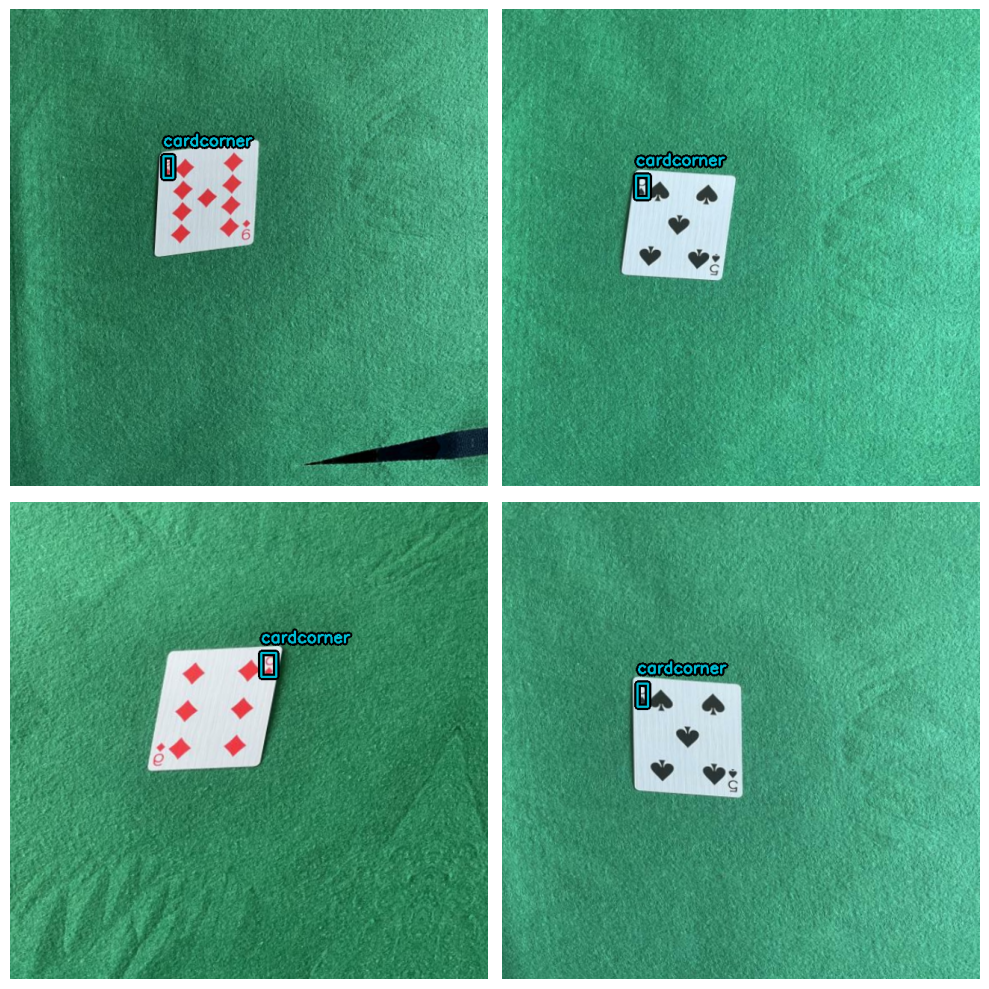

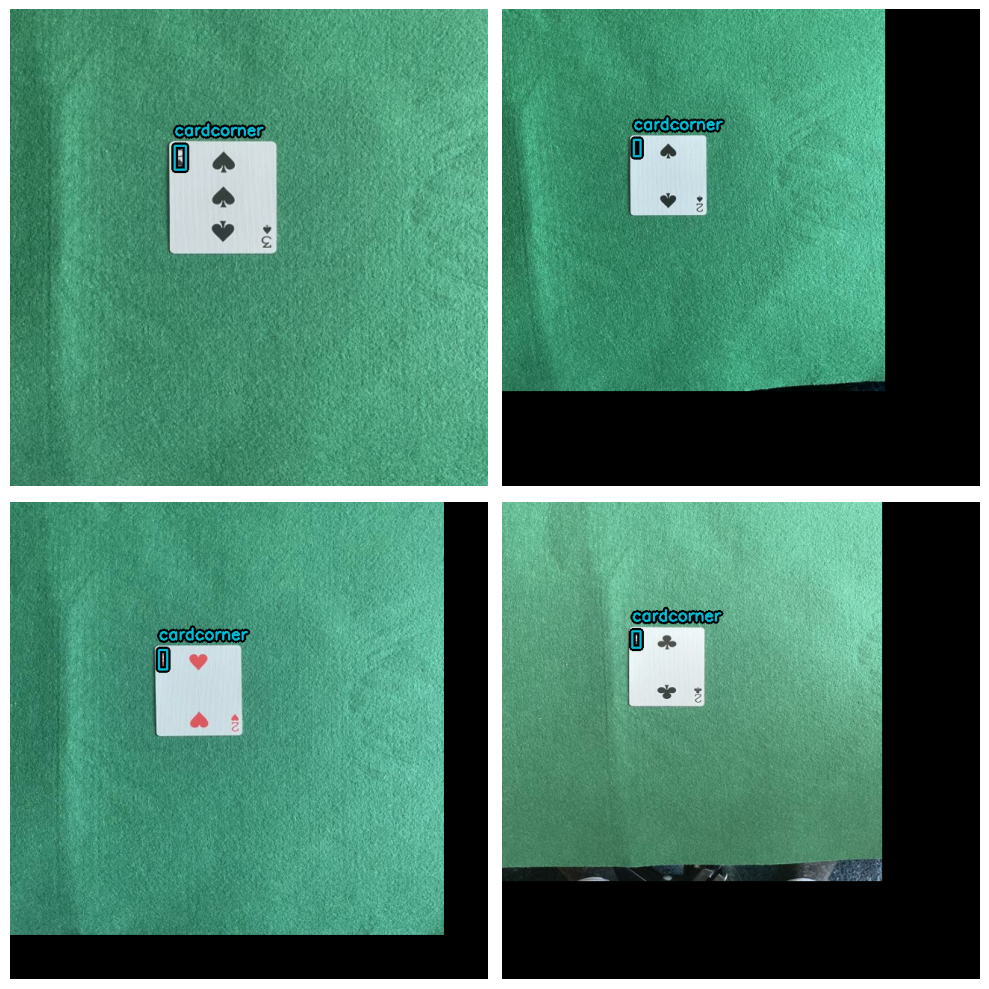

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

We need to extract the inputs from the preprocessing dictionary and get them ready to be
fed into the model.

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

## Creating Model

YOLOv8 is a cutting-edge YOLO model that is used for a variety of computer vision tasks,
such as object detection, image classification, and instance segmentation. Ultralytics,
the creators of YOLOv5, also developed YOLOv8, which incorporates many improvements and
changes in architecture and developer experience compared to its predecessor. YOLOv8 is
the latest state-of-the-art model that is highly regarded in the industry.

Below table compares the performance metrics of five different YOLOv8 models with
different sizes (measured in pixels): YOLOv8n, YOLOv8s, YOLOv8m, YOLOv8l, and YOLOv8x.
The metrics include mean average precision (mAP) values at different
intersection-over-union (IoU) thresholds for validation data, inference speed on CPU with
ONNX format and A100 TensorRT, number of parameters, and number of floating-point
operations (FLOPs) (both in millions and billions, respectively). As the size of the
model increases, the mAP, parameters, and FLOPs generally increase while the speed
decreases. YOLOv8x has the highest mAP, parameters, and FLOPs but also the slowest
inference speed, while YOLOv8n has the smallest size, fastest inference speed, and lowest
mAP, parameters, and FLOPs.

| Model                                                                                |
size<br><sup>(pixels) | mAP<sup>val<br>50-95 | Speed<br><sup>CPU ONNX<br>(ms) |
Speed<br><sup>A100 TensorRT<br>(ms) | params<br><sup>(M) | FLOPs<br><sup>(B) |
| ------------------------------------------------------------------------------------ |
--------------------- | -------------------- | ------------------------------ |
----------------------------------- | ------------------ | ----------------- |
| YOLOv8n | 640                   | 37.3                 | 80.4
| 0.99                                | 3.2                | 8.7               |
| YOLOv8s | 640                   | 44.9                 | 128.4
| 1.20                                | 11.2               | 28.6              |
| YOLOv8m | 640                   | 50.2                 | 234.7
| 1.83                                | 25.9               | 78.9              |
| YOLOv8l | 640                   | 52.9                 | 375.2
| 2.39                                | 43.7               | 165.2             |
| YOLOv8x | 640                   | 53.9                 | 479.1
| 3.53                                | 68.2               | 257.8             |

You can read more about YOLOV8 and its architecture in this
[RoboFlow Blog](https://blog.roboflow.com/whats-new-in-yolov8/)

First we will create a instance of backbone which will be used by our yolov8 detector
class.

YOLOV8 Backbones available in KerasCV:

1.   Without Weights:

    1.   yolo_v8_xs_backbone
    2.   yolo_v8_s_backbone
    3.   yolo_v8_m_backbone
    4.   yolo_v8_l_backbone
    5.   yolo_v8_xl_backbone

2. With Pre-trained coco weight:

    1.   yolo_v8_xs_backbone_coco
    2.   yolo_v8_s_backbone_coco
    2.   yolo_v8_m_backbone_coco
    2.   yolo_v8_l_backbone_coco
    2.   yolo_v8_xl_backbone_coco



In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xl_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

Next, let's build a YOLOV8 model using the `YOLOV8Detector`, which accepts a feature
extractor as the `backbone` argument, a `num_classes` argument that specifies the number
of object classes to detect based on the size of the `class_mapping` list, a
`bounding_box_format` argument that informs the model of the format of the bbox in the
dataset, and a finally, the feature pyramid network (FPN) depth is specified by the
`fpn_depth` argument.

It is simple to build a YOLOV8 using any of the aforementioned backbones thanks to
KerasCV.

In [ ]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=3,
)

## Compile the Model

Loss used for YOLOV8


1. Classification Loss: This loss function calculates the discrepancy between anticipated
class probabilities and actual class probabilities. In this instance,
`binary_crossentropy`, a prominent solution for binary classification issues, is
Utilized. We Utilized binary crossentropy since each thing that is identified is either
classed as belonging to or not belonging to a certain object class (such as a person, a
car, etc.).

2. Box Loss: `box_loss` is the loss function used to measure the difference between the
predicted bounding boxes and the ground truth. In this case, the Complete IoU (CIoU)
metric is used, which not only measures the overlap between predicted and ground truth
bounding boxes but also considers the difference in aspect ratio, center distance, and
box size. Together, these loss functions help optimize the model for object detection by
minimizing the difference between the predicted and ground truth class probabilities and
bounding boxes.


In [ ]:
# !pip install tf_keras --quiet

In [ ]:
# os.environ["TF_USE_LEGACY_KERAS"] = "True"
# from tensorflow.keras.optimizers.legacy import Adam
from keras.optimizers import Adam
optimizer = Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou", jit_compile=False
)

## COCO Metric Callback

We will be using `BoxCOCOMetrics` from KerasCV to evaluate the model and calculate the
Map(Mean Average Precision) score, Recall and Precision. We also save our model when the
mAP score improves.

In [ ]:

class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs


## Train the Model

In [ ]:
# print(train_ds.element_spec)

In [ ]:
# def resize_images(images, labels):
#     # Replace (target_height, target_width) with the dimensions expected by your model
#     target_height = 224  # Example height
#     target_width = 224   # Example width
#     resized_images = tf.image.resize(images, [target_height, target_width])
#     return resized_images, labels

# # Apply the resize function to each element in the dataset
# train_ds = train_ds.map(resize_images)


In [ ]:
# yolo.summary()

In [ ]:
# tf.config.optimizer.set_jit(True)
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "big_model.keras")],
    verbose=1,
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - loss: 45560.9219 - val_loss: 57774.8008 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 906ms/step - loss: 19324.8496 - val_loss: 53892.0625 - MaP: 0.0000e+00 - MaP@[IoU=50]: 0.0000e+00 - MaP@[IoU=75]: 0.0000e+00 - MaP@[area=small]: 0.0000e+00 - MaP@[area=medium]: 0.0000e+00 - MaP@[area=large]: 0.0000e+00 - Recall@[max_detections=1]: 0.0000e+00 - Recall@[max_detections=10]: 0.0000e+00 - Recall@[max_detections=100]: 0.0000e+00 - Recall@[area=small]: 0.0000e+00 - Recall@[area=medium]: 0.0000e+00 - Recall@[area=large]: 0.0000e+00
Epoch 3/50
10/10 ━━━━━━━━━━━━

## Visualize Predictions

getting image
running inference
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
Convert to ragged
visualizing


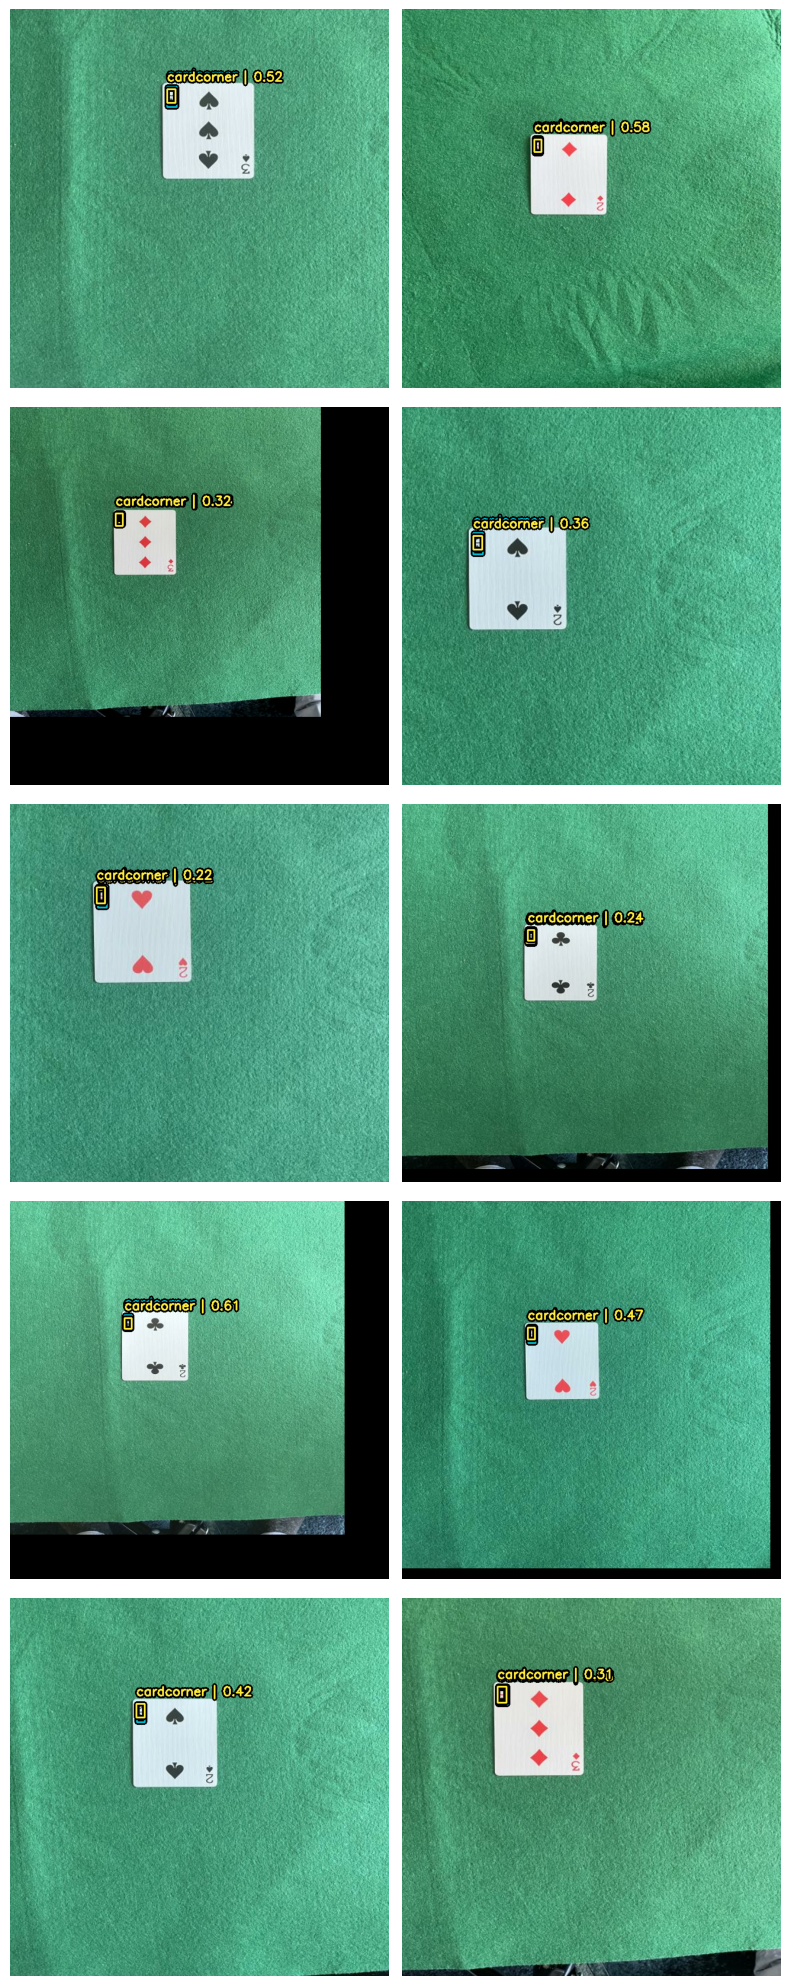

In [ ]:

def visualize_detections(model, dataset, bounding_box_format):
    print("getting image")
    images, y_true = next(iter(dataset.take(1)))
    print("running inference")
    y_pred = model.predict(images)
    print("Convert to ragged")
    # This line was throwing an error
    # y_pred = bounding_box.to_ragged(y_pred)
    print("visualizing")
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=5,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")

<class 'tensorflow.python.framework.ops.EagerTensor'>
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


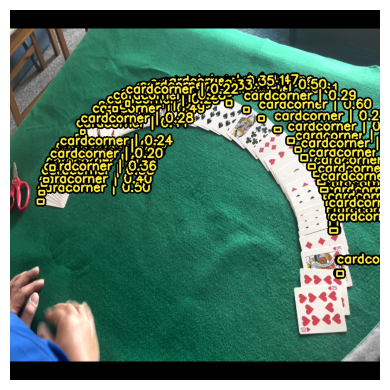

In [ ]:
def resize_images(images):
    # Replace (target_height, target_width) with the dimensions expected by your model
    target_height = 640  # Example height
    target_width = 640   # Example width
    resized_images = tf.image.resize(images, [target_height, target_width])
    return resized_images

# yolo.predict(tf.reshape(load_image("full_test.png"), (1, 640, 640, 3)))
test_img = load_image("full_test.png")
print(type(test_img))
resized = tf.image.resize(test_img, [640, 640])
resized = tf.reshape(resized, [1, 640, 640, 3])
y_pred = yolo.predict(resized)

visualization.plot_bounding_box_gallery(
    resized,
    value_range=(0, 255),
    bounding_box_format="xyxy",
    y_pred=y_pred,
    scale=4,
    rows=1,
    cols=1,
    show=True,
    font_scale=0.7,
    class_mapping=class_mapping,
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp big_model.keras /content/drive/MyDrive